In [1]:
import sys
sys.path.insert(0,'../')
import seaborn as sns
from functions import lib_table_operations as lto
from functions import data_processing as dp


/home/labs/barkailab/tamarj/TF_combinatorics/Submission/data_upload/figures_code/../functions/data_processing.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  info['gene_id'] = params.GENE_NAMES.index(info['gene'].upper())  # getting the gene ID (based on GP)
/home/labs/barkailab/tamarj/TF_combinatorics/Submission/data_upload/figures_code/../functions/data_processing.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  info['gene_id'] = params.GENE_NAMES.index(info['gene'].upper())  # getting the gene ID (based on GP)


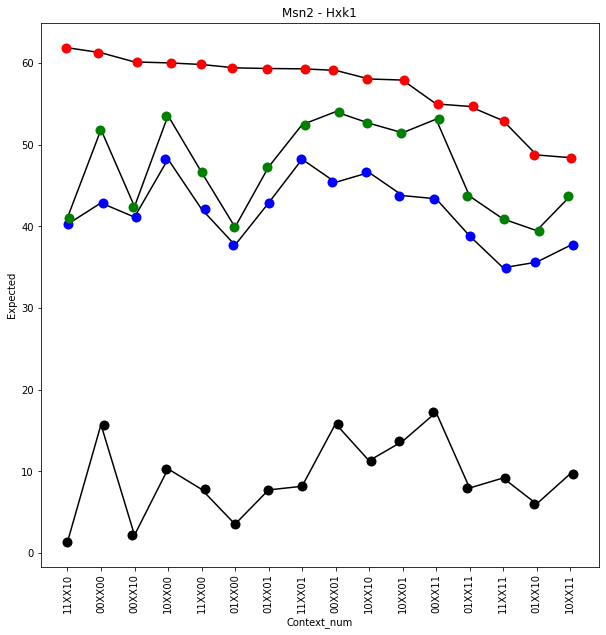

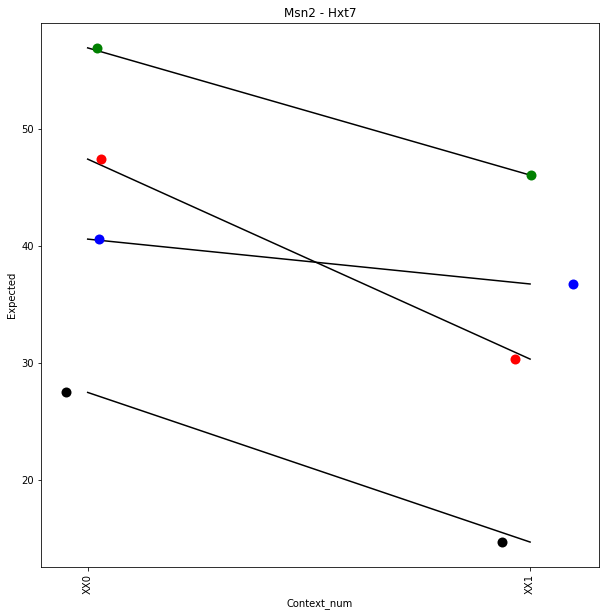

In [2]:
tf = 'Msn2'
libs = ['87','86']
exp = '13'
combs = [[2,3],[0,1]]
tp = '180'

for i in range(len(libs)):
    
    lib_num = libs[i]
    comb = combs[i]
    
    comb_df = lto.comb_opts_by_context(tf,lib_num,exp, comb, tp)
    
    comb_df_norm = comb_df.iloc[:,0:3] - comb_df.iloc[:,3].to_frame().values
    comb_df_norm['Context'] = comb_df['Context'] 
    comb_df = comb_df_norm
    
    
    comb_df_expected = comb_df.copy()
    comb_df_rel =  comb_df[['++','+-','-+']]
    comb_df_rel = lto.convert_fc_to_occ(comb_df_rel)
    comb_df_rel['Expected'] = 1-((1-comb_df_rel['+-'])*(1-comb_df_rel['-+']))
    comb_df_rel = comb_df_rel*100

    lib_info = dp.get_lib_info(lib_num)
    wt_var_seq = lib_info['wt_at_var_loc']  # get wild-type sequence
    context_nums = []
    for seq in comb_df['Context'].values:
        seq = list(seq)
        seq.insert(comb[0], 'X')
        seq.insert(comb[1], 'X')
        seq = np.array(seq)
        for i,nuc in enumerate(seq):
            if nuc == wt_var_seq[i]:
                seq[i] = '1'
            elif nuc == 'X':
                continue
            else:
                seq[i] = '0'

        context_nums.append(''.join(seq))
    comb_df_rel['Context_num'] = context_nums

    opts_dots = ['++', '+-', '-+','Expected']

    comb_df_rel.sort_values(by='++', ascending=False, inplace=True)
    cols = ['r','b','k','g']
    comb_df_rel.sort_values(by='++')
    comb_df_rel.reset_index(drop=True, inplace=True)
    figure, ax = plt.subplots(1,1,figsize=(10,10))
    axes = []
    for i, opt in enumerate(opts_dots):
        curr_ax = sns.stripplot(data=comb_df_rel, x='Context_num', y=opt, color=cols[i],s=10, ax=ax)
        sns.lineplot(data=comb_df_rel, x=comb_df_rel.index, y=opt, color='k', ax=ax)
        axes.append(curr_ax)
    plt.xticks(rotation = 90)
    ax.set_title(tf +' - '+ lib_info['gene'])
